# Importing Dataset from Kaggle

In [ ]:
!unzip /content/shai-training-multi-label.zip

# Importing the libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import glob #this for the files directory
import tqdm
import os
import shutil
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping


# Image Labeling

In [ ]:
def labeled_images(path):
    data = {'image_path': [], 'image_label': []}
    label_mapping = {
        'black_dress': 0,
        'black_pants': 1,
        'black_shirt': 2,
        'black_shoes': 3,
        'black_shorts': 4,
        'blue_dress': 5,
        'blue_pants': 6,
        'blue_shirt': 7,
        'blue_shoes': 8,
        'blue_shorts': 9,
        'brown_pants': 10,
        'brown_shoes': 11,
        'brown_shorts': 12,
        'green_pants': 13,
        'green_shirt': 14,
        'green_shoes': 15,
        'green_shorts': 16,
        'red_dress': 17,
        'red_pants': 18,
        'red_shoes': 19,
        'white_dress': 20,
        'white_pants': 21,
        'white_shoes': 22,
        'white_shorts': 23
    }


    reverse_mapping = {v: k for k, v in label_mapping.items()}  # Reverse mapping dictionary

    for dir_name in os.listdir(path):
        if not os.path.isdir(os.path.join(path, dir_name)):
            continue

        label = label_mapping.get(dir_name)
        if label is None:
            continue

        dir_path = os.path.join(path, dir_name)
        for file_name in os.listdir(dir_path):
            image_path = os.path.join(dir_path, file_name)
            data['image_path'].append(image_path)
            data['image_label'].append(reverse_mapping[label])  # Append label name instead of the numerical value

    df = pd.DataFrame(data)
    return df

In [ ]:
df= labeled_images('/content/train')


# Data Splitting

In [ ]:
from sklearn.model_selection import train_test_split
train, test= train_test_split(df, test_size=0.20, random_state=1)
train.shape, test.shape

((8196, 2), (2050, 2))

# Image Augmentation and Data Pipline

In [ ]:
train_datagen = ImageDataGenerator(rescale=1.0/255,
                                  zoom_range=0.2,
                                  shear_range = 0.2,
                                  brightness_range=(0.2, 1),
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  fill_mode='nearest')
train_generator = train_datagen.flow_from_dataframe(train,x_col='image_path',y_col='image_label',
                                                   target_size=(128, 128),
                                                   batch_size=32,
                                                   class_mode='categorical',
                                                   shuffle=True)

Found 8196 validated image filenames belonging to 24 classes.


In [ ]:
test_datagen = ImageDataGenerator(rescale = 1./255)
test_generator = test_datagen.flow_from_dataframe(test,x_col='image_path',y_col='image_label',
                                                   target_size=(128, 128),
                                                   batch_size=32,
                                                   class_mode='categorical',
                                                   shuffle=True)

Found 2050 validated image filenames belonging to 24 classes.


In [ ]:
labels = {value: key for key, value in train_generator.class_indices.items()}

print("Label Mappings for classes present in the training and validation datasets\n")
for key, value in labels.items():
    print(f"{key} : {value}")

Label Mappings for classes present in the training and validation datasets

0 : black_dress
1 : black_pants
2 : black_shirt
3 : black_shoes
4 : black_shorts
5 : blue_dress
6 : blue_pants
7 : blue_shirt
8 : blue_shoes
9 : blue_shorts
10 : brown_pants
11 : brown_shoes
12 : brown_shorts
13 : green_pants
14 : green_shirt
15 : green_shoes
16 : green_shorts
17 : red_dress
18 : red_pants
19 : red_shoes
20 : white_dress
21 : white_pants
22 : white_shoes
23 : white_shorts


# Plot  images

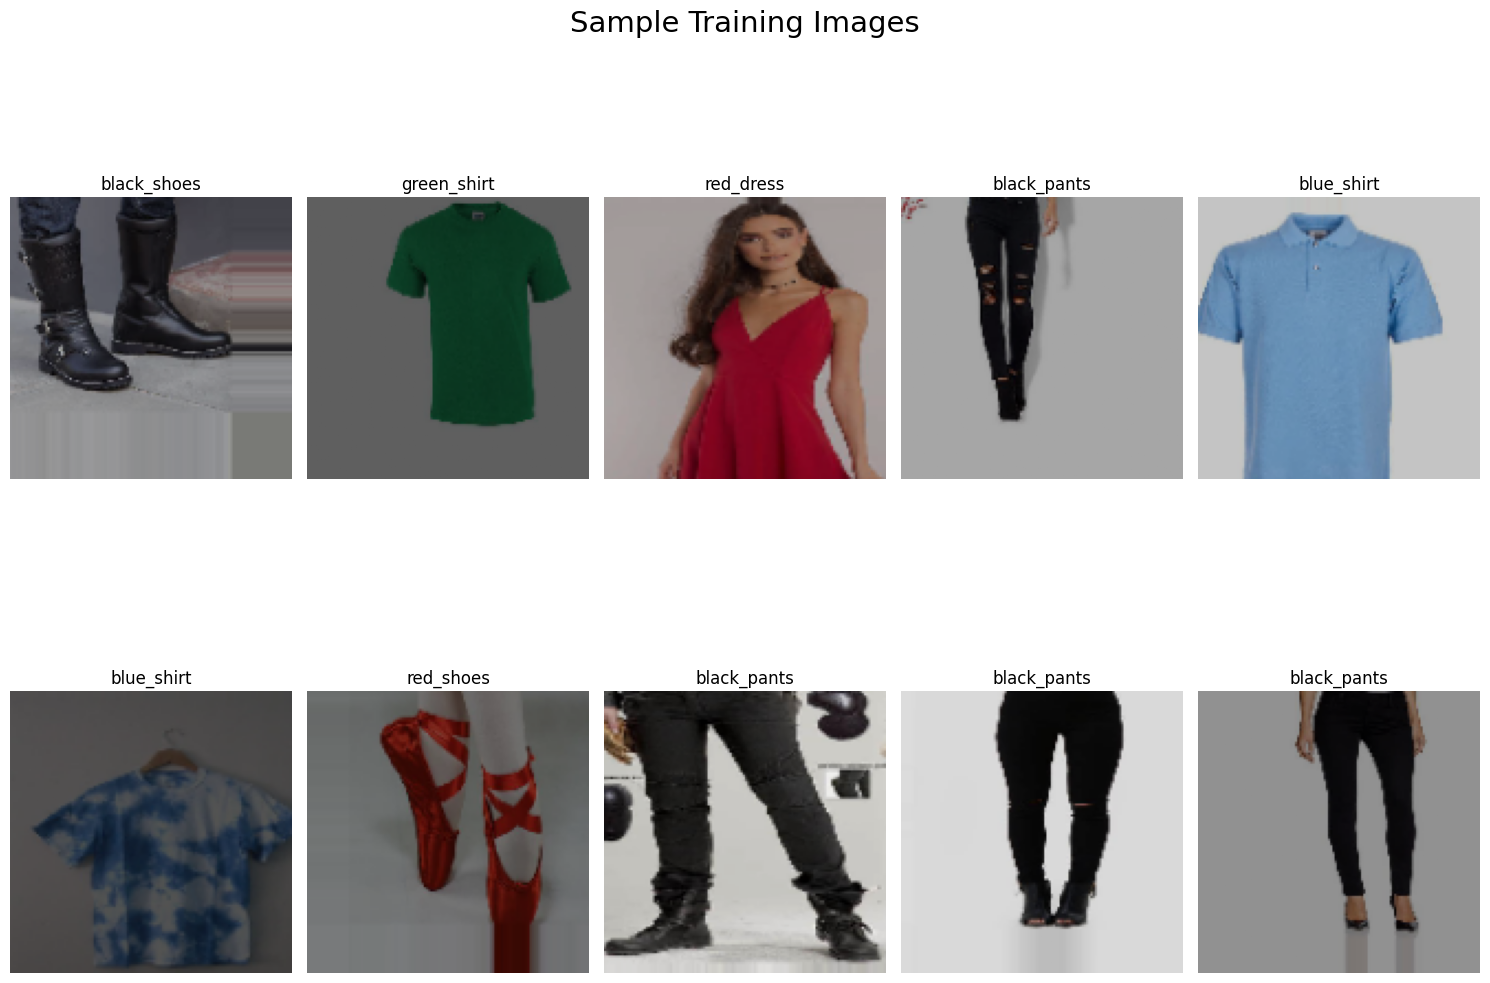

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(15, 12))
idx = 0

for i in range(2):
    for j in range(5):
        label = labels[np.argmax(train_generator[0][1][idx])]
        ax[i, j].set_title(f"{label}")
        ax[i, j].imshow(train_generator[0][0][idx][:, :, :])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.suptitle("Sample Training Images", fontsize=21)
plt.show()

# Build the Model

In [ ]:
transfer_model= tf.keras.applications.InceptionResNetV2(include_top= False, input_shape=(128,128,3),
                                                classes=24 )
transfer_model.trainable= False
transfer_model.summary()

219055592/219055592 [==============================] - 10s 0us/step
Model: "inception_resnet_v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 63, 63, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 63, 63, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
            

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, BatchNormalization, Conv2D, Dense, Dropout, Flatten, MaxPooling2D,GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.regularizers import l2

def create_model():
    model = Sequential([

        transfer_model,
        BatchNormalization(),
        GlobalAveragePooling2D(),
        Dense(units=256, activation='relu'),
        Dense(units=128, activation='relu'),
        Dropout(0.5),
        Dense(units=24, activation='softmax')
    ])

    # Unfreeze the last few layers for fine-tuning
    for layer in model.layers[-10:]:
        layer.trainable = True

    return model

In [ ]:
cnn_model = create_model()
print(cnn_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Functi  (None, 2, 2, 1536)       54336736  
 onal)                                                           
                                                                 
 batch_normalization_203 (Ba  (None, 2, 2, 1536)       6144      
 tchNormalization)                                               
                                                                 
 global_average_pooling2d (G  (None, 1536)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               393472    
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                        

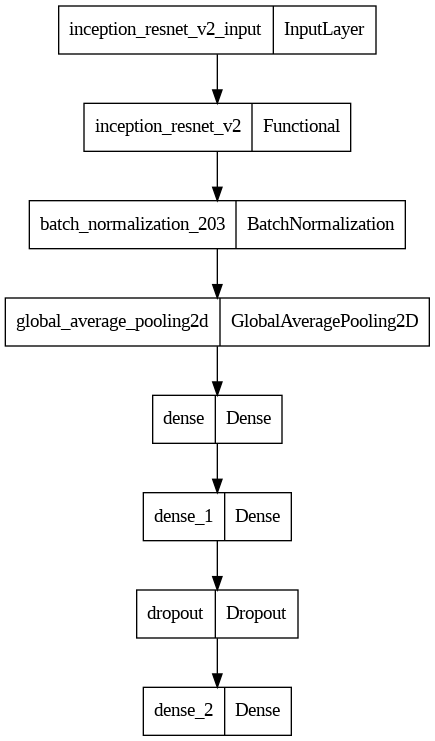

In [ ]:
tf.keras.utils.plot_model(cnn_model)

# Compile and Train the Model

In [ ]:
cnn_model.compile(optimizer='adam', loss=CategoricalCrossentropy(), metrics=['accuracy'])

In [ ]:
early = tf.keras.callbacks.EarlyStopping( patience=7,
                                          min_delta=0.001,
                                          restore_best_weights=True)

history = cnn_model.fit(train_generator, epochs=30, validation_data=test_generator,
                        callbacks=[early])

Epoch 1/30
257/257 [==============================] - 225s 419ms/step - loss: 1.3771 - accuracy: 0.6274 - val_loss: 0.6692 - val_accuracy: 0.8132
Epoch 2/30
257/257 [==============================] - 100s 389ms/step - loss: 0.7403 - accuracy: 0.8038 - val_loss: 0.4381 - val_accuracy: 0.8717
Epoch 3/30
257/257 [==============================] - 99s 385ms/step - loss: 0.5625 - accuracy: 0.8496 - val_loss: 0.6826 - val_accuracy: 0.8288
Epoch 4/30
257/257 [==============================] - 99s 385ms/step - loss: 0.5193 - accuracy: 0.8658 - val_loss: 0.6901 - val_accuracy: 0.8083
Epoch 5/30
257/257 [==============================] - 100s 387ms/step - loss: 0.4687 - accuracy: 0.8719 - val_loss: 0.4338 - val_accuracy: 0.8815
Epoch 6/30
257/257 [==============================] - 99s 387ms/step - loss: 0.3762 - accuracy: 0.8973 - val_loss: 0.4139 - val_accuracy: 0.8898
Epoch 7/30
257/257 [==============================] - 99s 385ms/step - loss: 0.3689 - accuracy: 0.9003 - val_loss: 0.5722 - val

# Plotting the Model Metrics

In [ ]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']



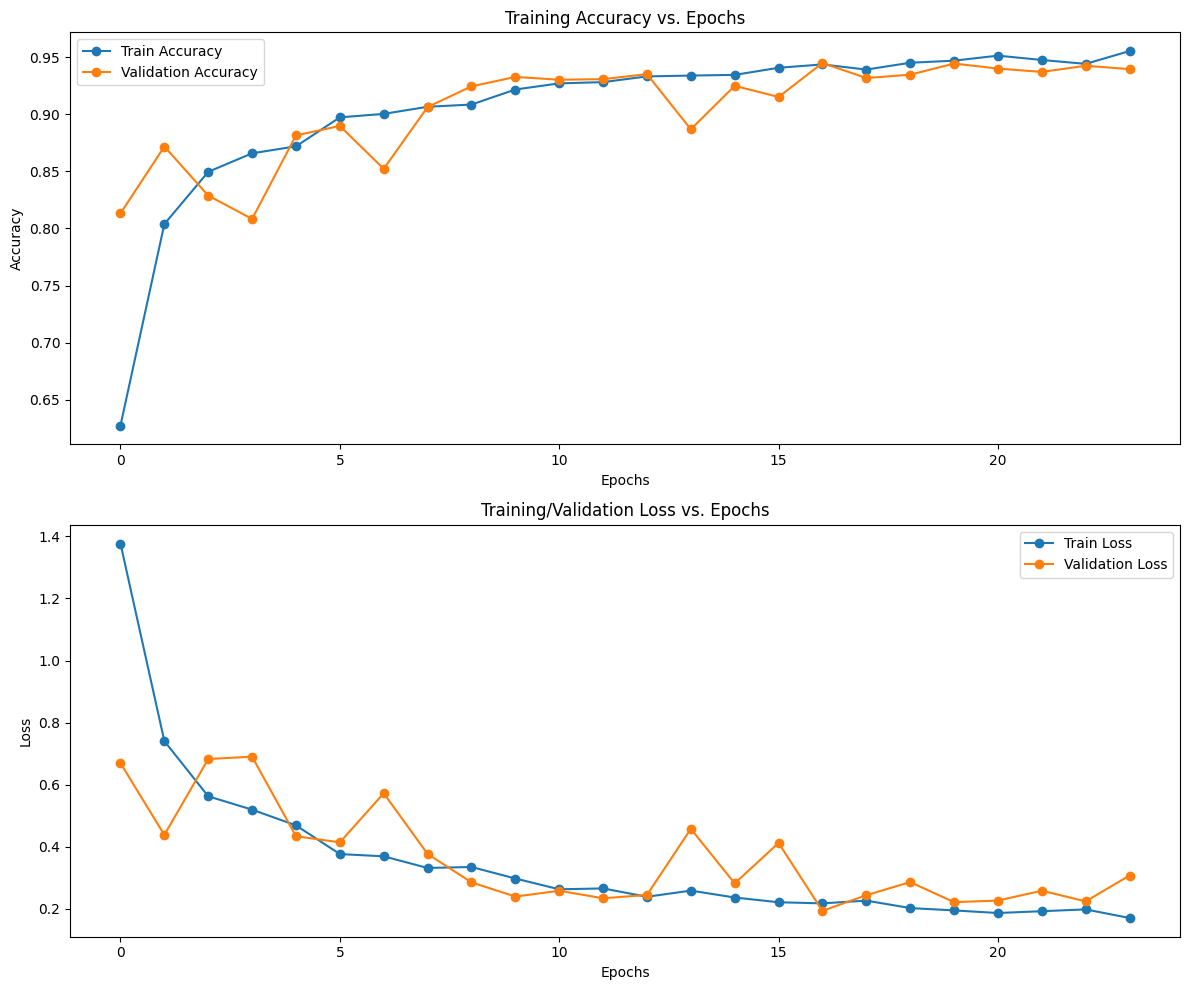

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 10))

ax[0].set_title('Training Accuracy vs. Epochs')
ax[0].plot(train_accuracy, 'o-', label='Train Accuracy')
ax[0].plot(val_accuracy, 'o-', label='Validation Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(loc='best')

ax[1].set_title('Training/Validation Loss vs. Epochs')
ax[1].plot(train_loss, 'o-', label='Train Loss')
ax[1].plot(val_loss, 'o-', label='Validation Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(loc='best')

plt.tight_layout()
plt.show()

# Model Prediction on the Test Dataset

In [ ]:
!unzip /content/Labeled_Test.zip

In [ ]:
test_datagen = ImageDataGenerator(rescale=1.0/255)

test_generator = test_datagen.flow_from_directory('/content/Labeled_Test',
                                                 shuffle=False,
                                                 batch_size=32,
                                                 target_size = (128, 128), class_mode='categorical')

Found 1139 images belonging to 24 classes.


In [ ]:
# Perform predictions on the test images using the generator
predictions = cnn_model.predict(test_generator)

36/36 [==============================] - 10s 194ms/step


36/36 [==============================] - 5s 133ms/step


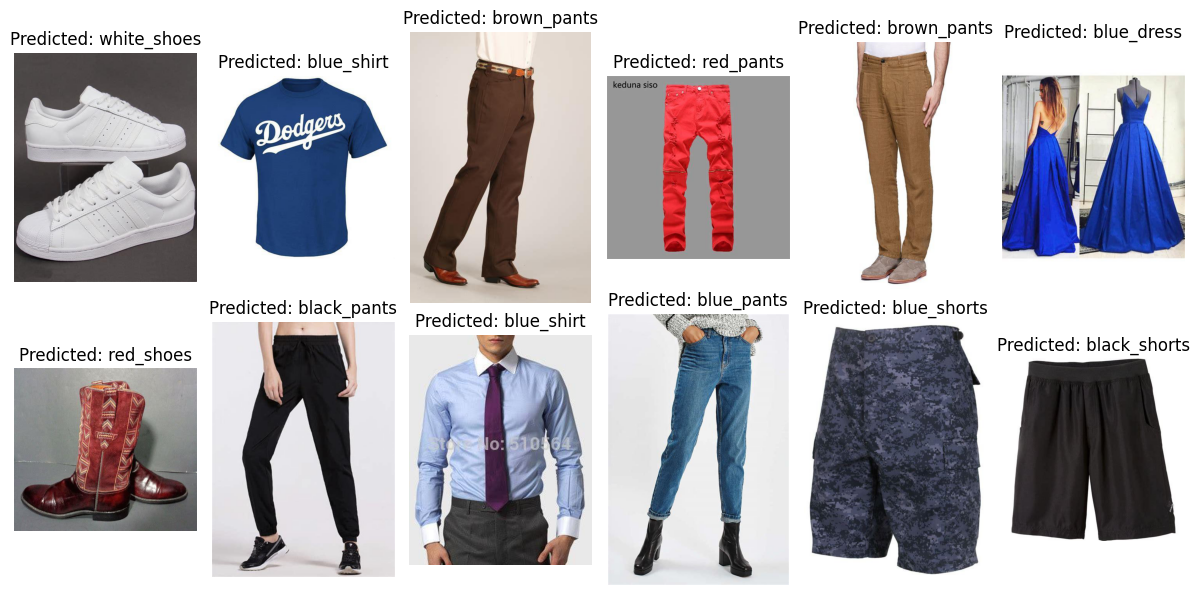

In [ ]:
import random

# Get the predicted labels for all data
predictions = cnn_model.predict(test_generator)
num_samples = 12

# Get a random subset of indices
indices = random.sample(range(len(predictions)), num_samples)

# Get the predicted labels and corresponding filenames for the selected indices
predicted_labels = np.argmax(predictions[indices], axis=1)
filenames = [test_generator.filenames[i] for i in indices]


# Create a grid of subplots to display the images
fig, axes = plt.subplots(2, 6, figsize=(12, 6))
axes = axes.ravel()

# Loop over the images and their predicted labels to plot them
for i in range(num_samples):
    # Load and display the image
    img = plt.imread('/content/Labeled_Test' + '/' + filenames[i])
    axes[i].imshow(img)
    axes[i].axis('off')
    axes[i].set_title('Predicted: {}'.format(label_names[predicted_labels[i]]))

plt.tight_layout()
plt.show()

# Model Evaluation on the Test dataset

## Testing Accuracy Evaluation

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = cnn_model.evaluate(test_generator)

# Print the test loss and accuracy
print('Test Loss: {:.3f}'.format(test_loss))
print('Test Accuracy: {:.2%}'.format(test_accuracy))

36/36 [==============================] - 6s 150ms/step - loss: 0.2414 - accuracy: 0.9394
Test Loss: 0.241
Test Accuracy: 93.94%


In [ ]:
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=labels.values()))

              precision    recall  f1-score   support

 black_dress       0.98      0.89      0.93        47
 black_pants       1.00      0.97      0.98        89
 black_shirt       0.93      0.96      0.94        70
 black_shoes       0.95      0.86      0.90        80
black_shorts       0.93      0.80      0.86        35
  blue_dress       0.96      0.92      0.94        49
  blue_pants       0.96      0.88      0.92        81
  blue_shirt       0.94      0.99      0.96        73
  blue_shoes       0.78      0.92      0.84        49
 blue_shorts       0.62      0.87      0.73        23
 brown_pants       1.00      1.00      1.00        30
 brown_shoes       0.94      0.98      0.96        46
brown_shorts       1.00      1.00      1.00         4
 green_pants       1.00      0.83      0.91        24
 green_shirt       0.92      0.96      0.94        23
 green_shoes       0.92      1.00      0.96        46
green_shorts       0.82      1.00      0.90        14
   red_dress       0.98    